In [242]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import torch

In [243]:
# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets

X

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,4
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,6
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,yes,yes,no,5,4,2,1,2,5,4
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,yes,yes,no,4,3,4,1,1,1,4
646,MS,F,18,U,GT3,T,1,1,other,other,...,yes,no,no,1,1,1,1,1,5,6
647,MS,M,17,U,LE3,T,3,1,services,services,...,yes,yes,no,2,4,5,3,4,2,6


# Clustering
## K-Means + PCA

Selected 11 numerical columns: ['age', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


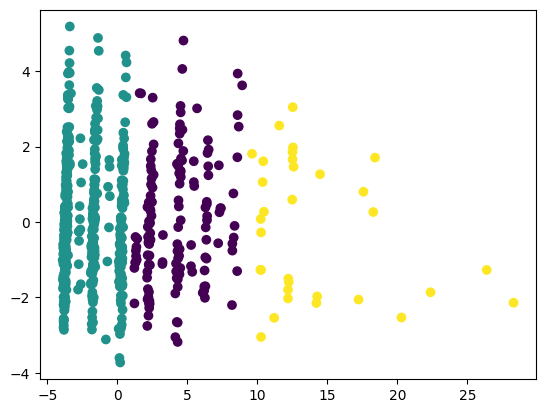

In [244]:
numericalColumns = X.select_dtypes(exclude=['object', 'bool']).columns
numericalColumns = list(numericalColumns)
numericalColumns.remove('Medu')
numericalColumns.remove('Fedu')
print(f"Selected {len(numericalColumns)} numerical columns: {numericalColumns}")

# k-means
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(X[numericalColumns])

# use PCA to reduce dimensions to 2
pca = PCA(n_components=2).fit(X[numericalColumns])
datapoint = pca.transform(X[numericalColumns])

# plot
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=kmeans.labels_)
plt.show()

## Auto-Encoders

In [245]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, inputSize : int, embeddingSize : int, intermediateLayers : list[int]) -> None:
        super().__init__()
        self.inputSize = inputSize
        self.embeddingSize = embeddingSize
        self.intermediateLayers = intermediateLayers
        self.encoder = torch.nn.Sequential()
        self.decoder = torch.nn.Sequential()
        
        if (len(intermediateLayers) == 0):
            self.encoder.add_module(f"encoder_0", torch.nn.Linear(self.inputSize, self.embeddingSize))
            self.decoder.add_module(f"decoder_0", torch.nn.Linear(self.embeddingSize, self.inputSize))
            return

        # encoder
        self.encoder.add_module(f"encoder_0", torch.nn.Linear(self.inputSize, self.intermediateLayers[0]))
        self.encoder.add_module(f"encoder_activation_0", torch.nn.ReLU())
        for i in range(1, len(self.intermediateLayers)):
            self.encoder.add_module(f"encoder_{i}", torch.nn.Linear(self.intermediateLayers[i-1], self.intermediateLayers[i]))
            self.encoder.add_module(f"encoder_activation_{i}", torch.nn.ReLU())
        self.encoder.add_module(f"encoder_{len(self.intermediateLayers)}", torch.nn.Linear(self.intermediateLayers[-1], self.embeddingSize))

        # decoder
        self.decoder.add_module(f"decoder_0", torch.nn.Linear(self.embeddingSize, self.intermediateLayers[0]))
        self.decoder.add_module(f"decoder_activation_0", torch.nn.ReLU())
        for i in range(1, len(self.intermediateLayers)):
            self.decoder.add_module(f"decoder_{i}", torch.nn.Linear(self.intermediateLayers[i-1], self.intermediateLayers[i]))
            self.decoder.add_module(f"decoder_activation_{i}", torch.nn.ReLU())
        self.decoder.add_module(f"decoder_{len(self.intermediateLayers)}", torch.nn.Linear(self.intermediateLayers[-1], self.inputSize))
        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        h = x
        x = self.decoder(x)
        return x, h

Epoch 0: 32.754735
Epoch 10: 2.893345
Epoch 20: 2.845755
Epoch 30: 2.814010
Epoch 40: 2.787376
Epoch 50: 2.760459
Epoch 60: 2.720759
Epoch 70: 2.638204
Epoch 80: 0.950532
Epoch 90: 0.951748
Epoch 100: 0.940631
Epoch 110: 0.934364
Epoch 120: 0.931806
Epoch 130: 0.929367
Epoch 140: 0.926682
Epoch 150: 0.923683
Epoch 160: 0.920547
Epoch 170: 0.917418
Epoch 180: 0.914873
Epoch 190: 0.912818
Epoch 200: 0.911703
Epoch 210: 0.911394
Epoch 220: 0.909840
Epoch 230: 0.909127
Epoch 240: 0.906671
Epoch 250: 0.902985
Epoch 260: 0.898647
Epoch 270: 0.894441
Epoch 280: 0.891825
Epoch 290: 0.891853


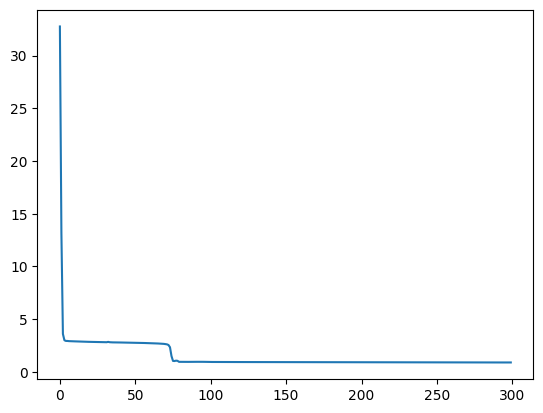

In [246]:
numericalColumns = X.select_dtypes(exclude=['object', 'bool']).columns
numericalColumns = list(numericalColumns)
numericalColumns.remove('Medu')
numericalColumns.remove('Fedu')
# no need to remove categorical columns as the neural network will automatically adjust for them

model = AutoEncoder(len(numericalColumns), 2, [16, 8])
epochs = 300
lr = 0.006
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

trainLoss = []
for epoch in range(epochs):
    # divide into batches
    runningLoss = 0
    for i in range(0, len(X[numericalColumns]), 32):
        optimizer.zero_grad()
        output, _ = model(torch.tensor(X[numericalColumns].iloc[i:i+32].values, dtype=torch.float))
        loss = criterion(output, torch.tensor(X[numericalColumns].iloc[i:i+32].values, dtype=torch.float))
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    trainLoss.append(runningLoss / (len(X[numericalColumns]) / 32))
    if (epoch % 10 == 0):
        print(f"Epoch {epoch}: {trainLoss[-1]:3f}")

# plot
plt.plot(trainLoss)
plt.show()

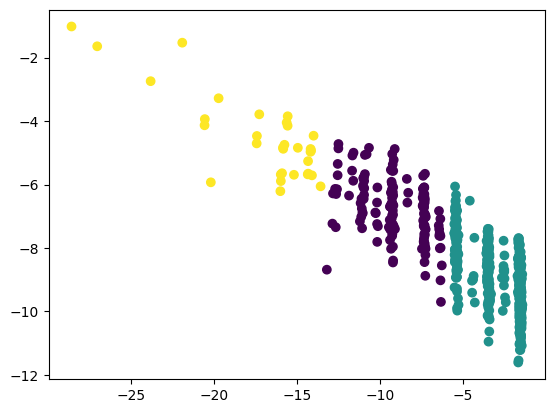

In [247]:
with torch.no_grad():
    embeddings = model.encoder(torch.tensor(X[numericalColumns].values, dtype=torch.float)).detach().numpy()
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=kmeans.labels_)
plt.show()

The clustering suggests the exisitence of special groups.

In [249]:
# print the average score of each student cluster
X['cluster'] = kmeans.labels_
X['G3'] = y['G3']
X[numericalColumns + ['cluster']].groupby('cluster').mean()

/tmp/ipykernel_16098/2070012430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = kmeans.labels_
/tmp/ipykernel_16098/2070012430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['G3'] = y['G3']


,age,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
cluster,,,,,,,,,,,
0,16.966887,1.562914,1.834437,0.264901,3.735099,3.099338,3.390728,1.622517,2.576159,3.456954,7.834437
1,16.641631,1.570815,1.982833,0.190987,4.000000,3.214592,3.120172,1.422747,2.150215,3.555794,1.341202
2,17.187500,1.562500,1.625000,0.468750,3.843750,3.062500,3.156250,2.093750,2.781250,3.625000,17.718750
